#### Problem Statement:

Steam has established itself as one of the most prominent digital distribution platforms for PC gaming, hosting thousands of titles and attracting millions of users worldwide. For my final project, I aim to develop a predictive model capable of determining whether a user will recommend a game based on a combination of game features and user behavior. The recommendation status, represented as a binary outcome (is_recommended), serves as a valuable indicator of a game’s quality, popularity, and user satisfaction.

This model may be particularly useful for game developers, publishers, and platform managers seeking to identify the key factors that drive positive recommendations. By understanding which attributes—such as price, playtime, discounts, and reviews—most influence user satisfaction, stakeholders can make data-driven decisions to improve user engagement, optimize pricing strategies, and prioritize game features that resonate with their audience.

The successful development of this model will not only enhance the ability to predict user recommendations but will also provide actionable insights for stakeholders in the gaming industry. Game developers can align their design choices with player preferences, marketing teams can target the most engaged users effectively, and the Steam platform can improve its game discovery algorithms to maximize user satisfaction. Furthermore, analyzing trends in user behavior and game popularity will offer a deeper understanding of how the gaming landscape has evolved over time, contributing to strategic planning and decision-making in this dynamic and competitive industry.

In [1]:
import pandas as pd
import numpy as np

games = pd.read_csv('data/games.csv')
users = pd.read_csv('data/users.csv')
recommendations = pd.read_csv('data/recommendations.csv')

In [2]:
print("Games:\n", games.head(), "\n")
print("Users:\n", users.head(), "\n")
print("Recommendations:\n", recommendations.head(), "\n")

Games:
    app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   discount  steam_deck  
0   

In [3]:
print(games.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 non-null  float64
 11  discount        50872 non-null  float64
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.7+ MB
None


In [4]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB
None


In [5]:
print(recommendations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 2.2+ GB
None


Instead of processing the entire dataset, we select a small, representative portion of the data for all subsequent operations.


In [10]:
# Select the top 500 most-reviewed games
selected_games = games.sort_values('user_reviews', ascending=False).head(500)

# Save the filtered games to ensure consistency
selected_games.to_csv('data/selected_games.csv', index=False)
print(f"Selected Games: {selected_games.shape}")

Selected Games: (500, 13)


In [13]:
# Select users with at least 40 reviews
active_users = users[users['reviews'] >= 40]

# Save the filtered users for consistency
active_users.to_csv('data/selected_users.csv', index=False)
print(f"Highly Active Users: {active_users.shape}")

Highly Active Users: (57973, 3)


In [16]:
# Filter recommendations for selected games and active users
filtered_recommendations = recommendations[
    (recommendations['app_id'].isin(selected_games['app_id'])) &
    (recommendations['user_id'].isin(active_users['user_id']))
]

print(f"Recommendations after filtering: {filtered_recommendations.shape}")

Recommendations after filtering: (1466223, 8)


In [19]:
# Randomly sample 15% of the filtered recommendations
sampled_recommendations = filtered_recommendations.sample(frac=0.15, random_state=42)

# Save the sampled recommendations
sampled_recommendations.to_csv('data/sampled_recommendations.csv', index=False)
print(f"Sampled Recommendations: {sampled_recommendations.shape}")

Sampled Recommendations: (219933, 8)


In [25]:
# Merge 'date_release' into the final dataset
final_dataset = sampled_recommendations.merge(
    selected_games[['app_id', 'price_final', 'discount', 'positive_ratio', 'date_release']],
    on='app_id',
    how='left'
)

# Save the final dataset for reuse
final_dataset.to_csv('data/final_dataset.csv', index=False)
print(f"Final Dataset Size: {final_dataset.shape}")

Final Dataset Size: (219933, 12)


In [27]:
print(final_dataset.columns)

Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id', 'price_final', 'discount', 'positive_ratio',
       'date_release'],
      dtype='object')


In [28]:
# Convert 'date_release' to datetime
final_dataset['date_release'] = pd.to_datetime(final_dataset['date_release'], errors='coerce')

# Find the earliest and latest release year
earliest_year = final_dataset['date_release'].dt.year.min()
latest_year = final_dataset['date_release'].dt.year.max()

print(f"Earliest Release Year: {earliest_year}")
print(f"Latest Release Year: {latest_year}")

Earliest Release Year: 1998
Latest Release Year: 2023


The revised dataset that I will be working with contains detailed information on 500 of the most-reviewed games available on the Steam platform. These games, released between 1998 and 2023, span a wide range of genres, platforms, and pricing models.

## Exploratory Data Analysis

In [29]:
# Load the new datasets
final_games = pd.read_csv('data/selected_games.csv')  # 500 most-reviewed games
final_users = pd.read_csv('data/selected_users.csv')  # Users with >= 40 reviews
final_recommendations = pd.read_csv('data/sampled_recommendations.csv')  # 15% sampled recommendations

In [31]:
print("### Final Games Dataset")
print("Columns:", final_games.columns.tolist())
print(final_games.head())


### Final Games Dataset
Columns: ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']
   app_id                             title date_release   win    mac  linux  \
0     730  Counter-Strike: Global Offensive   2012-08-21  True   True   True   
1  578080               PUBG: BATTLEGROUNDS   2017-12-21  True  False  False   
2     570                            Dota 2   2013-07-09  True   True   True   
3  271590                Grand Theft Auto V   2015-04-13  True  False  False   
4  359550   Tom Clancy's Rainbow Six® Siege   2015-12-01  True  False  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              88       7494460         15.0             0.0   
1          Mixed              57       2217226          0.0             0.0   
2  Very Positive              82       2045628          0.0             0.0   
3  Very 

In [32]:
print("\n### Final Users Dataset")
print("Columns:", final_users.columns.tolist())
print(final_users.head())


### Final Users Dataset
Columns: ['user_id', 'products', 'reviews']
    user_id  products  reviews
0  11316351       677       68
1   4363012      1001       72
2   4893896       496       50
3   6366584      1597      129
4  11140739       286       79


In [33]:
print("\n### Final Recommendations Dataset")
print("Columns:", final_recommendations.columns.tolist())
print(final_recommendations.head())


### Final Recommendations Dataset
Columns: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id']
    app_id  helpful  funny        date  is_recommended  hours   user_id  \
0    55230        4      0  2016-11-23            True   42.5  11719461   
1   250900        2      0  2022-06-28            True   73.1   5995128   
2  1286830        2      2  2020-07-22           False  188.7  10213711   
3   377160        0      0  2017-05-26            True  264.8  14172991   
4   240720        0      0  2022-11-27            True   19.0  12274208   

   review_id  
0   22118917  
1    2195484  
2    2078355  
3    4796238  
4   17825487  


#### Descriptive Statistics

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
descriptive_stats = final_dataset[['price_final', 'discount', 'positive_ratio', 'hours']].describe()

print("### Descriptive Statistics")
print(descriptive_stats)

### Descriptive Statistics
         price_final       discount  positive_ratio          hours
count  219933.000000  219933.000000   219933.000000  219933.000000
mean       20.594121       3.154279       89.095111      76.823279
std        16.435132      15.314748        8.644655     140.955482
min         0.000000       0.000000       26.000000       0.000000
25%         7.990000       0.000000       86.000000       8.800000
50%        19.990000       0.000000       91.000000      24.800000
75%        30.000000       0.000000       95.000000      72.800000
max        70.000000      90.000000       98.000000     999.900000


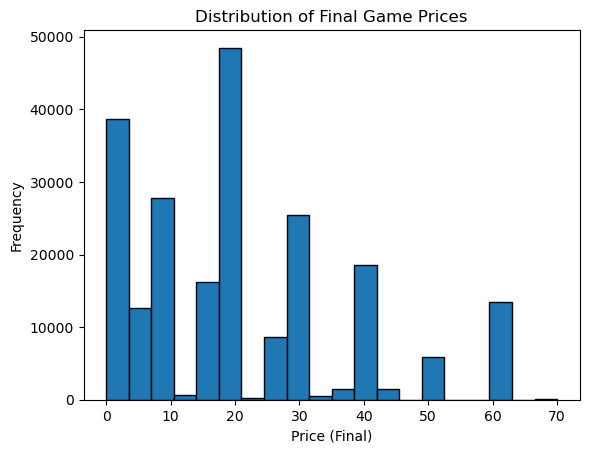

In [37]:
import matplotlib.pyplot as plt

plt.hist(final_dataset['price_final'], bins=20, edgecolor='black')
plt.title('Distribution of Final Game Prices')
plt.xlabel('Price (Final)')
plt.ylabel('Frequency')
plt.show()

The distribution of final game prices reveals a significant concentration at $0, emphasizing the popularity of free-to-play games among highly reviewed titles. Prices also tend to cluster around $10, $20, and $30, suggesting that mid-range pricing is a common strategy for game developers. Notably, fewer games are priced above $40, with the highest price reaching $70, indicating that premium-priced titles are less frequent and likely reserved for high-value or AAA games. This pattern highlights a balance between free-to-play models and mid-range pricing, with premium games forming a small, exclusive segment of the market.

#### Initial Visualizations

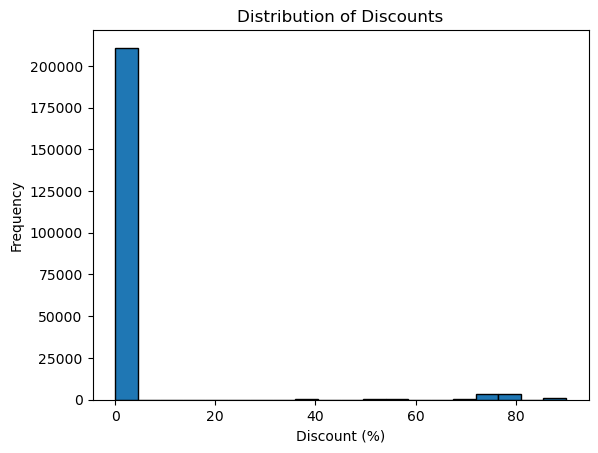

In [38]:
plt.hist(final_dataset['discount'], bins=20, edgecolor='black')
plt.title('Distribution of Discounts')
plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.show()

The distribution of game discounts reveals that the majority of games receive no discount (0%), reflecting a strategy to maintain their base price. Only a small subset of games features discounts, with sporadic occurrences beyond the 20% mark. A slight increase is observed near 80%, likely tied to promotional events or heavy price cuts during sales. This pattern highlights that deep discounts are uncommon for top-reviewed games, as developers likely aim to preserve the perceived value of their titles.

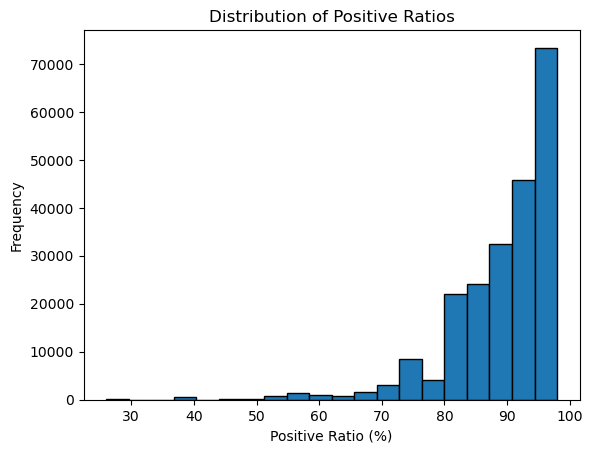

In [39]:
plt.hist(final_dataset['positive_ratio'], bins=20, edgecolor='black')
plt.title('Distribution of Positive Ratios')
plt.xlabel('Positive Ratio (%)')
plt.ylabel('Frequency')
plt.show()

The positive ratio distribution is skewed heavily toward higher values, with the majority of games achieving ratings above 80%. A notable concentration occurs between 90% and 95%, demonstrating that top-reviewed games are generally well-received. There is a sharp decline near 100%, indicating that while games are highly rated, achieving near-perfect scores is rare. This trend reinforces the notion that top-reviewed games consistently meet or exceed player expectations, reflecting their strong quality and widespread appeal on the Steam platform.

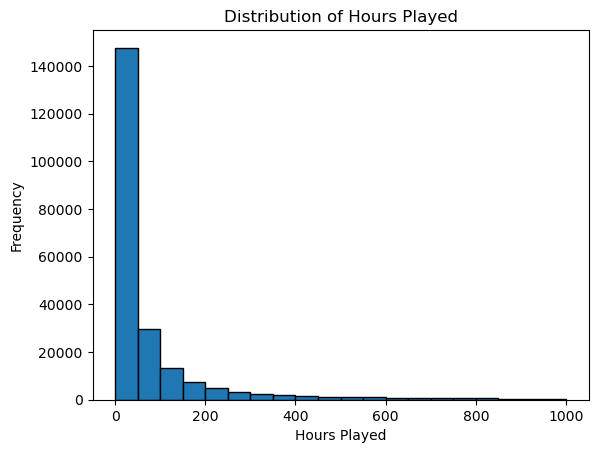

In [40]:
plt.hist(final_dataset['hours'], bins=20, edgecolor='black')
plt.title('Distribution of Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()

The distribution of hours played is highly skewed, with the majority of users playing for fewer than 50 hours. Playtime frequency decreases sharply as hours increase, but a small subset of users shows extreme engagement, with playtimes exceeding 200 hours and a few approaching 1,000 hours. This indicates that while most players interact with games for a moderate duration, a dedicated minority invests substantial time, reflecting a range of player engagement levels.

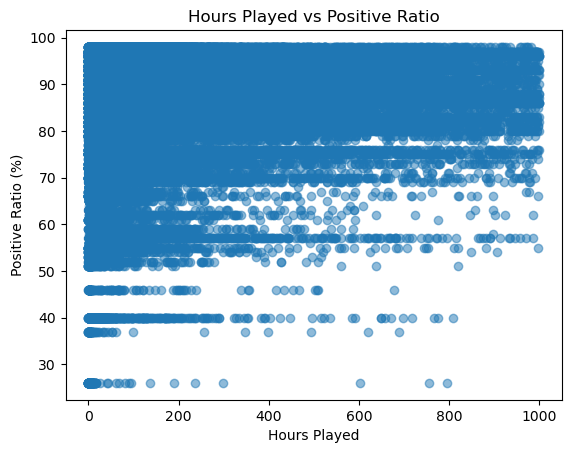

In [41]:
plt.scatter(final_dataset['hours'], final_dataset['positive_ratio'], alpha=0.5)
plt.title('Hours Played vs Positive Ratio')
plt.xlabel('Hours Played')
plt.ylabel('Positive Ratio (%)')
plt.show()

The Hours Played vs Positive Ratio plot shows that games with a higher positive ratio generally have a wide range of playtime, with many games achieving high ratings even at lower hours played. A significant concentration of points appears at positive ratios above 80%, regardless of playtime. However, games with extremely high playtime (e.g., 500+ hours) still maintain positive ratings, suggesting that sustained player engagement often correlates with user satisfaction. Lower positive ratios (below 50%) tend to cluster at lower playtime, implying that games with poor ratings fail to retain players for extended periods.

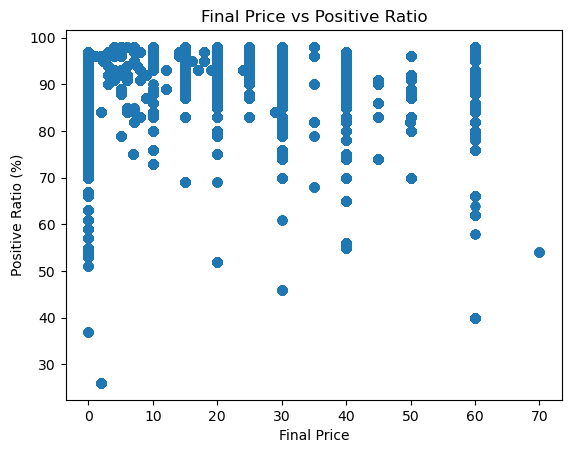

In [42]:
plt.scatter(final_dataset['price_final'], final_dataset['positive_ratio'], alpha=0.5)
plt.title('Final Price vs Positive Ratio')
plt.xlabel('Final Price')
plt.ylabel('Positive Ratio (%)')
plt.show()

The Final Price vs Positive Ratio plot reveals that highly-rated games (positive ratio above 80%) are distributed across all price levels, including free-to-play games priced at $0. However, the concentration of high ratings is most notable at lower price points. As prices increase, the positive ratio becomes more varied, with occasional games receiving lower ratings. This suggests that while lower-priced or free-to-play games are consistently well-received, higher-priced games are subject to greater scrutiny and may have more polarized feedback.

## Conclusion

The analysis of top-reviewed Steam games reveals key trends in pricing, player engagement, and satisfaction. Free-to-play and mid-range priced games dominate, while premium-priced games ($40+) are less common. Discounts are rare, with most games maintaining their original price, reflecting a focus on preserving perceived value.

Player satisfaction is consistently high, with positive ratings skewed above 80% and peaking between 90–95%, highlighting strong overall game quality. Playtime is highly skewed, with most users playing under 50 hours, though a small subset invests 200+ hours, indicating high replay value for certain titles.

Games with higher positive ratings tend to sustain engagement across varying playtimes, while lower-rated games struggle to retain players for long durations. Similarly, lower-priced games receive more consistent positive feedback, whereas premium titles face greater scrutiny and polarized opinions.

In summary, affordability, quality, and player engagement are the key drivers of success in the competitive Steam gaming market.

## Modeling & Interpretations

To predict whether a user will recommend a game, I decided to use multiple classification models and compare their performance in accurately predicting recommendations and capturing patterns in the data. For each model, I utilized an 80-20 train-test split, where 80% of the data is used for training the model, and the remaining 20% is reserved for testing its performance. This approach ensures that the models are evaluated on unseen data, providing a reliable measure of their predictive accuracy and ability to generalize to new user-game interactions.

In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

#### Baseline Model

To predict whether a user will recommend a game, I started by creating a simple baseline regression model using the mean value of the target variable is_recommended. This baseline serves as a benchmark to measure the performance of more advanced models. Specifically, the model predicts the mean recommendation value for all observations, and I calculate the Mean Squared Error (MSE) to quantify how well this simple approach performs. This baseline provides a reference point for evaluating the ability of future models to capture patterns and reduce prediction errors.

In [47]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Load the final dataset
final_df = pd.read_csv('data/final_dataset.csv')

# Extract the target variable (is_recommended)
y = final_df['is_recommended']

# Baseline prediction: predict the mean value for all instances
baseline_preds = np.ones(len(y)) * y.mean()

# Calculate baseline MSE
baseline_mse = mean_squared_error(y, baseline_preds)

print(f"Baseline Mean Squared Error (MSE): {baseline_mse:.4f}")

Baseline Mean Squared Error (MSE): 0.1326


#### Multiple Regression Model

To improve upon the baseline model, I chose to build a multiple regression model to predict whether a user would recommend a game (is_recommended). This approach uses multiple independent variables, such as game features and user behavior, to predict the target variable. I believed that these predictors collectively influence the recommendation outcome, and multiple regression allows me to analyze their individual and combined effects on the prediction.

In [48]:
# Load the final dataset
final_df = pd.read_csv('data/final_dataset.csv')

# Define the feature matrix X and target variable y
X = final_df[['price_final', 'discount', 'positive_ratio', 'hours']]
y = final_df['is_recommended']


In [49]:
# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [51]:
# Create and train the regression pipeline
pipe = Pipeline([
    ('model', LinearRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('model', LinearRegression())])

In [52]:
# Extract model coefficients and intercept
lr = pipe.named_steps['model']
coefficients = lr.coef_
intercept = lr.intercept_
print("Model Coefficients:")
print(pd.DataFrame(coefficients, index=X.columns, columns=['Coefficient']))
print(f"Intercept: {intercept:.4f}")

Model Coefficients:
                Coefficient
price_final        0.000200
discount           0.000304
positive_ratio     0.011779
hours              0.000133
Intercept: -0.2216


In [53]:
# Calculate MSE for training data
y_train_preds = pipe.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_preds)
print(f"Training MSE: {train_mse:.4f}")


Training MSE: 0.1217


In [54]:
# Calculate MSE for testing data
y_test_preds = pipe.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_preds)
print(f"Testing MSE: {test_mse:.4f}")

Testing MSE: 0.1247


Overall, the multiple regression model outperformed the baseline, with both the training MSE (0.1217) and testing MSE (0.1247) being lower than the baseline MSE (0.1326). The model showed slightly better performance on the training data, which is expected as it was optimized on that set. This improvement indicates that the predictors—positive_ratio, discount, price_final, and hours—added meaningful value in predicting whether a game would be recommended, compared to the baseline, which relied only on the mean recommendation value.

Among the predictors, positive_ratio emerged as the strongest factor influencing recommendations, emphasizing the importance of user satisfaction in driving positive reviews. Discount and price_final had smaller but notable effects, suggesting that pricing strategies, including promotions, contribute to recommendations but to a lesser extent. Hours played had the weakest impact, indicating that while playtime provides some insight, it is less influential than user ratings and pricing decisions.

#### K-Nearest Neighbors Regression Model

Next, I decided to try the K-Nearest Neighbors (KNN) regression model, which predicts outcomes based on the similarity of data points in the feature space. This approach leverages local patterns, capturing relationships between games with similar features such as positive_ratio, discount, and hours. Since the initial visualizations suggested clustering patterns in some of these features, KNN could be particularly effective in modeling localized influences on game recommendations.

In [55]:
# Define X and y
X = final_df[['price_final', 'discount', 'positive_ratio', 'hours']]
y = final_df['is_recommended']

# Drop rows with missing values
X = X.dropna()
y = y[X.index]

In [56]:
# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


In [57]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
# Create KNN pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])


In [59]:
# Define hyperparameter grid
param_grid = {'model__n_neighbors': [5, 10, 15, 20, 25, 30]}

In [61]:
print(f"Training data size: {X_train.shape}")

Training data size: (175946, 4)


In [62]:
# Perform GridSearchCV for hyperparameter tuning with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [5, 10, 15, 20, 25, 30]},
             scoring='neg_mean_squared_error')

In [64]:
# Print all best parameters to see the correct key name
print("Best Parameters:", grid_search.best_params_)

# Get the correct hyperparameter name dynamically
best_k = list(grid_search.best_params_.values())[0]  # Extract first (and only) value
print(f"Best number of neighbors: {best_k}")

Best Parameters: {'model__n_neighbors': 30}
Best number of neighbors: 30


In [65]:
# Use the best estimator from GridSearchCV
best_knn = grid_search.best_estimator_

In [66]:
# Predict on the training data and calculate the training MSE
y_train_preds = best_knn.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_preds)
print(f"Training MSE: {train_mse:.4f}")

Training MSE: 0.1088


In [67]:
# Predict on the testing data and calculate the testing MSE
y_test_preds = best_knn.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_preds)
print(f"Testing MSE: {test_mse:.4f}")

Testing MSE: 0.1184


In [68]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(best_knn, X_test, y_test, n_repeats=10, random_state=20)

# Store feature importance in a DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result['importances_mean']
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importance:")
print(feature_importance)

Feature Importance:
          Feature  Importance
2  positive_ratio    0.169290
3           hours    0.139096
0     price_final    0.048664
1        discount    0.003540


My KNN model outperformed both the baseline and the multiple regression model, with a training MSE of 0.1088 and a testing MSE of 0.1184, demonstrating its ability to generalize well. While the model performed slightly better on the training data, the testing performance remained strong, highlighting the effectiveness of KNN in capturing non-linear patterns in the data. The use of grid search for hyperparameter tuning likely contributed to this improvement, as selecting the optimal number of neighbors (30) helped fine-tune the model for better accuracy.

Among the features, positive_ratio emerged as the most important predictor, emphasizing the significant role of user satisfaction in determining game recommendations. Hours played also showed substantial importance, indicating that user engagement plays a key role. Price_final had a smaller impact, while discount contributed minimally, suggesting that pricing strategies have less influence compared to ratings and engagement. Overall, the KNN model leveraged these features effectively to capture complex relationships in the data and improve recommendation predictions.

#### Decision Tree Regression Model

I chose to build a decision tree regression model because, similar to k-nearest neighbors, decision trees are capable of capturing non-linear relationships within the dataset. Additionally, decision trees provide a clear and interpretable decision-making process, offering insights into how the model generates predictions based on feature values. This interpretability helps identify the factors influencing the target variable, such as the final price, discount, and positive review ratio in the context of game recommendations.

In [69]:
# Create X & y, split into training and testing data
X = final_df[['price_final', 'discount', 'positive_ratio', 'hours']]
y = final_df['is_recommended']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [70]:
# Find the optimal max depth while avoiding overfitting by plotting the test accuracies
train_scores = []
test_scores = []
for d in range(1, 20):
    dtree = DecisionTreeRegressor(max_depth=d).fit(X_train, y_train)
    y_train_preds = dtree.predict(X_train)
    y_test_preds = dtree.predict(X_test)
    train_scores.append(mean_squared_error(y_train, y_train_preds))
    test_scores.append(mean_squared_error(y_test, y_test_preds))


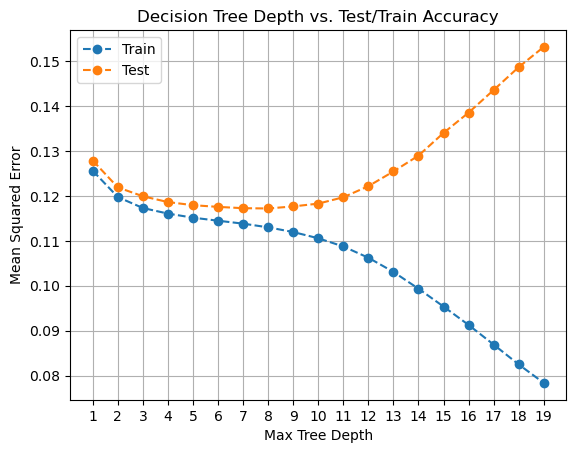

In [71]:
plt.plot(range(1, 20), train_scores, '--o', label='Train')
plt.plot(range(1, 20), test_scores, '--o', label='Test')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('Max Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Depth vs. Test/Train Accuracy')
plt.show()


In [72]:
# Fit a decision tree model with the optimal max depth (e.g., lowest MSE from the graph)
optimal_depth = test_scores.index(min(test_scores)) + 1  # Adjusting for index starting at 0
dtree = DecisionTreeRegressor(max_depth=optimal_depth).fit(X_train, y_train)


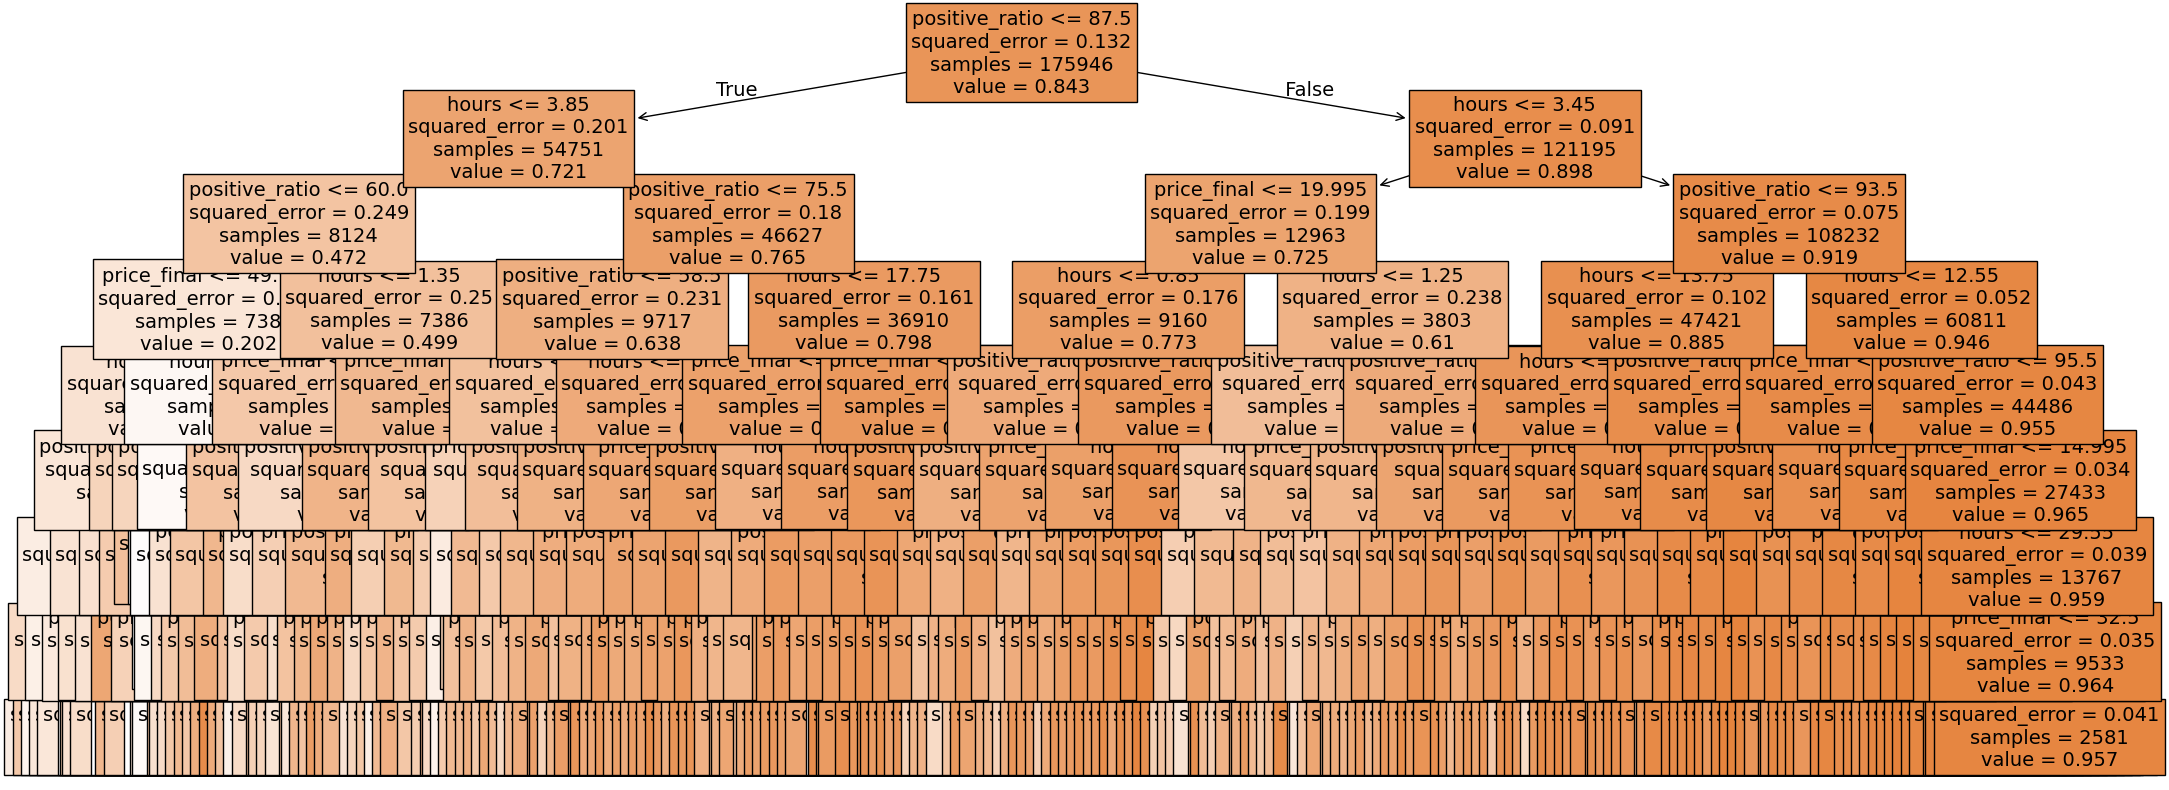

In [73]:
# Plot the decision tree
plt.figure(figsize=(25, 10))
plot_tree(dtree, filled=True, feature_names=X.columns, fontsize=14)
plt.show()

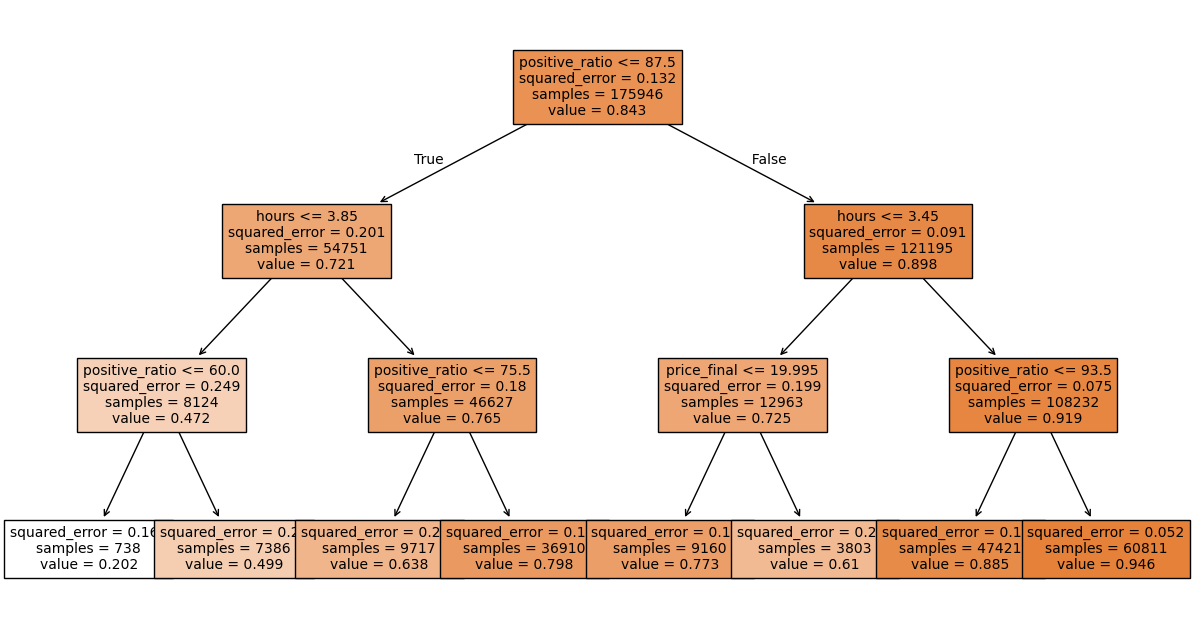

In [76]:
# Refit the Decision Tree with stricter constraints
dtree_simpler = DecisionTreeRegressor(
    max_depth=3,             
    min_samples_split=100,   
    min_samples_leaf=50,    
    max_leaf_nodes=20,       
    random_state=20
).fit(X_train, y_train)

plt.figure(figsize=(15, 8))
plot_tree(dtree_simpler, filled=True, feature_names=X.columns, fontsize=10)
plt.show()


In [77]:
# Evaluate the simplified tree
y_train_preds = dtree_simpler.predict(X_train)
y_test_preds = dtree_simpler.predict(X_test)

train_mse_simple = mean_squared_error(y_train, y_train_preds)
test_mse_simple = mean_squared_error(y_test, y_test_preds)

print(f"Simplified Tree Training MSE: {train_mse_simple:.4f}")
print(f"Simplified Tree Testing MSE: {test_mse_simple:.4f}")

Simplified Tree Training MSE: 0.1173
Simplified Tree Testing MSE: 0.1199


In [78]:
# Compute feature importance using permutation importance
r = permutation_importance(dtree_simpler, X_test, y_test, n_repeats=10, random_state=20)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': r['importances_mean']
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

          Feature  Importance
2  positive_ratio    0.120900
3           hours    0.089798
0     price_final    0.005584
1        discount    0.000000


While my decision tree model’s performance on the training data outperformed the baseline and multiple regression models, it performed slightly worse than the K-Nearest Neighbors (KNN) model. This discrepancy could be attributed to the selected max depth of 3, which may not have captured the underlying complexities and non-linear relationships within the data as effectively as the KNN model did. By limiting the tree’s depth, the model primarily relied on a small subset of features, potentially overlooking important interactions in the data.

In this case, positive_ratio and hours emerged as the two most important features for predicting whether a game is recommended, with permutation importance values of 0.1209 and 0.0898, respectively. However, price_final and discount were deemed far less significant, with discount contributing nothing at all (importance = 0). This result suggests that the simplified decision tree focused on a narrower set of predictors, which may explain its slightly lower performance compared to the KNN model.

#### Random Forest Regression Model

For my last model, I decided to extend my decision tree model into a random forest regression model. Since my single decision tree performed well, I wanted to explore ensemble methods like random forest for further improvement, since they combine multiple trees to improve predictive performance.

In [82]:
# Create X & y, split into training and testing data
X = final_df[['price_final', 'discount', 'positive_ratio', 'hours']]
y = final_df['is_recommended']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 4, 5, 6]
}

# Create a pipeline for encoding and modeling
pipe = Pipeline([
    ('model', RandomForestRegressor(random_state=20))
])

In [83]:
# Perform grid-search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'model__max_depth': 6, 'model__n_estimators': 150}


In [84]:
forest = grid_search.best_estimator_

In [85]:
# Evaluate the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_preds)
test_mse = mean_squared_error(y_test, y_test_preds)

print(f"Random Forest Training MSE: {train_mse:.4f}")
print(f"Random Forest Testing MSE: {test_mse:.4f}")

Random Forest Training MSE: 0.1139
Random Forest Testing MSE: 0.1169


In [86]:
# Determine feature importance
r = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=20)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': r['importances_mean']
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", feature_importance)

Feature Importance:
           Feature  Importance
2  positive_ratio    0.130880
3           hours    0.118837
0     price_final    0.013835
1        discount    0.000154


Overall, my random forest model achieved the best performance among all the models I developed, with a testing MSE of 0.1169. This was slightly better than the K-Nearest Neighbors (KNN) model, which had a testing MSE of 0.1184. The random forest also demonstrated improved generalization compared to the single decision tree, showcasing the advantage of ensemble learning methods.

Once again, positive_ratio and hours emerged as the most significant features, with permutation importance values of 0.1309 and 0.1188, respectively. Price_final contributed minimally, and discount remained nearly irrelevant with an importance value close to zero. This consistent result across models emphasizes that user reviews and playtime are the key predictors in determining whether a game is recommended.

#### Summary of Findings

In my analysis of game recommendations on Steam, all the models I developed demonstrated improved performance over the baseline predictor, indicating their utility in predicting user recommendations. The models ranked in terms of performance, based on their testing mean squared errors (MSE), are as follows: Random Forest Regression, K-Nearest Neighbors Regression (KNN), Decision Tree Regression, and Multiple Linear Regression.

Key Findings:
1. Success of the Random Forest Model:
The Random Forest model emerged as the most effective, achieving the lowest testing mean squared error (MSE) of 0.1169, outperforming the K-Nearest Neighbors model (0.1184) and the Decision Tree model (0.1199). This performance highlights the model’s ability to capture complex, non-linear patterns within the data, while mitigating overfitting through its ensemble approach.

2. Impactful Features:
Across all models, positive_ratio (percentage of positive reviews) and hours (user playtime) consistently emerged as the most important features influencing predictions: Random Forest feature importance:
        •positive_ratio: 0.1309
        •hours: 0.1188
Conversely, price_final (final price) contributed marginally (0.0138) and discount had an almost negligible impact (0.0002).

3. Variable Influence Across Models:
    The consistent dominance of positive_ratio and hours across models demonstrates the strong influence of user sentiment and playtime on game recommendations. While price_final showed limited importance, discount had virtually no contribution across all models, suggesting that user behavior is driven more by engagement and reviews than by pricing or discounts.

## Next Steps & Discussion

Next Steps for Enhancing Predictive Models

To further improve the predictive capabilities of the models and gain deeper insights into game recommendations, I plan to incorporate the following additional features and analyses based on the provided data:

- User behavior and demographics will be added by incorporating user-specific features like the number of products owned and reviews made. This will help better understand user engagement levels and behaviors, which may influence whether a game is recommended. Users with more products or reviews may have a more critical perspective, impacting recommendation likelihood.

- Game ratings and release details will also be included. The rating column (e.g., Very Positive, Mixed) provides categorical insights into user sentiment and can serve as a strong predictor when encoded. The release date will allow for the extraction of temporal patterns, such as trends over time, where older games may have different recommendation rates compared to newer ones. Additionally, platform compatibility data, including Windows, Mac, Linux, and Steam Deck support, can reveal how accessibility impacts user recommendations.

- Review characteristics, such as the helpful and funny votes from user reviews, will also be analyzed. These metrics can uncover engagement levels with user reviews, which may indirectly reflect the quality of a game. Incorporating the review date allows for the analysis of temporal trends, capturing potential impacts of updates or recent events on user recommendations.

- Text feature extraction from game titles and descriptions will be explored using Natural Language Processing (NLP) techniques. Methods such as TF-IDF vectorization or word embeddings will help analyze keywords and recurring themes in game titles and descriptions. For instance, specific words like “Ultimate,” “Deluxe,” or “Simulator” could influence user recommendations and reveal trends in player preferences.

- Finally, financial and pricing data will be further analyzed by considering price patterns, such as price_original, price_final, and discount. Expanding this analysis over time will allow me to identify whether discounts or specific pricing strategies contribute to game recommendations. Additionally, incorporating financial data, such as average revenue per user if available, could further connect economic success with user recommendations.

By integrating user behavior, review characteristics, text-based analysis, and financial data, the models will become more comprehensive, offering deeper insights into the factors influencing game recommendations. These enhancements will refine the models’ predictive power, uncover hidden relationships within the data, and provide actionable insights for game developers and industry stakeholders.